Data Downloaded From https://archive.ics.uci.edu/dataset/1/abalone

In [1]:
install.packages("ggplot2", repos = "http://cran.us.r-project.org")
install.packages("GGally", repos = "http://cran.us.r-project.org")
install.packages('glmnet')
install.packages('car')
install.packages('leaps')

library(ggplot2)
library(GGally)
library(glmnet)
library(car)
library(leaps)
library(dplyr)

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: Matrix

Loaded glmnet 4.1-8

Loading required package: carData


Attaching package: ‘dplyr’


The following object is masked from ‘package:car’:

    recode


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
url <- "https://raw.githubusercontent.com/pbrar17/stat_301_gp/main/abalone/abalone.data"

data = read.csv(url, header = FALSE)

colnames(data) <- c("Sex", "Length (mm)", "Diameter (mm)", "Height (mm)", "Whole_weight (g)", "Shucked_weight (g)", "Viscera_weight (g)", "Shell_weight (g)", "Rings")
cat('Number of total Raw Observations: ', nrow(data), '\n')
# Removes Duplicates
data <- unique(data)
cat('Number of Unique Observations with possible missing values: ',nrow(data), '\n')

#Dealing With Missing Values
    #We were told that there are no missing values, but its always a good idea to ensure that is the case.
    #So in the event we have NA values:
        #Since we are using this data to predict, I think the best thing would be to just remove the rows with na values, 
        #we could fill them with the mean for that varaible, but that could impact the accuarcy of our prediction model.

data <- na.omit(data)
cat('Number of Unique Observations after dealing with missing values: ',nrow(data), '\n')

#based on the output of nrow, it seems there were no missing values as expected


data$Sex <- factor(data$Sex, levels = c("M", "F", "I"), ordered = FALSE)

#Looks to be in a clean and tidy fromat
head(data)
cat('Number of observations after cleaning: ',nrow(data), '\n')

Number of total Raw Observations:  4177 
Number of Unique Observations with possible missing values:  4177 
Number of Unique Observations after dealing with missing values:  4177 


,Sex,Length (mm),Diameter (mm),Height (mm),Whole_weight (g),Shucked_weight (g),Viscera_weight (g),Shell_weight (g),Rings
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
2,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
3,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
4,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
5,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
6,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


Number of observations after cleaning:  4177 



Based on the above outputs, our data is pretty clean, and looking at the Data Type for each variable, everything makes sense.
The only thing we had to change was that we had to make Sex factor from type Character.

In [3]:
summary(data)

 Sex       Length (mm)    Diameter (mm)     Height (mm)     Whole_weight (g)
 M:1528   Min.   :0.075   Min.   :0.0550   Min.   :0.0000   Min.   :0.0020  
 F:1307   1st Qu.:0.450   1st Qu.:0.3500   1st Qu.:0.1150   1st Qu.:0.4415  
 I:1342   Median :0.545   Median :0.4250   Median :0.1400   Median :0.7995  
          Mean   :0.524   Mean   :0.4079   Mean   :0.1395   Mean   :0.8287  
          3rd Qu.:0.615   3rd Qu.:0.4800   3rd Qu.:0.1650   3rd Qu.:1.1530  
          Max.   :0.815   Max.   :0.6500   Max.   :1.1300   Max.   :2.8255  
 Shucked_weight (g) Viscera_weight (g) Shell_weight (g)     Rings       
 Min.   :0.0010     Min.   :0.0005     Min.   :0.0015   Min.   : 1.000  
 1st Qu.:0.1860     1st Qu.:0.0935     1st Qu.:0.1300   1st Qu.: 8.000  
 Median :0.3360     Median :0.1710     Median :0.2340   Median : 9.000  
 Mean   :0.3594     Mean   :0.1806     Mean   :0.2388   Mean   : 9.934  
 3rd Qu.:0.5020     3rd Qu.:0.2530     3rd Qu.:0.3290   3rd Qu.:11.000  
 Max.   :1.4880     Max

Brief Desription of our Data
- There are 4177 instances/observations in the data.
- There are 9 variables in the data:
    - Sex which a catergoical variable which can be either Male, Female, or Infant.
    - Length of the logest shell, which is measured in mm and is continuous.
    - Diameter which is perpendicual to the Length, also measured in mm and is continuous.
    - Height with meat in the shell in mm and is continuous.
    - Whole Weight of the Abalone in grams and is continuous.
    - Shucked Weight, which is the entire weight of the meat in grams and is continuous.
    - Viscera Weight which is the weight of the gut after bleeding in grams and is continuous.
    - Shell Weight which is measured after the shell is dried in grams and is continuous.
    - Rings, the number of Rings present, adding 1.5 gives the age in terms of Years and is an Integer.
- There are no missing values
- They mention "the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200)." (Albalone, UCI)
This information was sourced from http://archive.ics.uci.edu/dataset/1/abalone, which is also where the data is from. 

We will be considering Rings to be continuous.

The question I want to answer using the Abalone dataset is which set of physical characteristic variables will provide the most accurate prediction of the number of rings of an Abalone. The number of rings will allow us to calculate the age of the Abalone. 

In order to answer this question, we need to examine all of the explanatory variables that we have, each of which represents a different physical characteristic. We need to compare the explanatory variables on their own to the response variable Rings but also among each other.

In order to obtain reliable results, it's essential to eliminate any confounding variables and address high correlations among predictors, a phenomenon known as multicollinearity. Multicollinearity adversely affects the standard error and can compromise the reliability of our predictions.

I opted for the ggpairs plot below, due to its ability to display correlations between variables, enabling us to identify and address multicollinearity. Furthermore, the plot categorizes the data into the three sex categories: Male, Female, and Infant. This division allows us to discern specific correlations, such as whether height strongly correlates with length in infants and males but not in females. Investigating such patterns is crucial.

Moreover, the plot provides insights into the distribution of each variable based on sex. For instance, when examining the length column, it becomes apparent that regardless of other parameters, infants are consistently shorter than male and female adults. This observation aligns with our expectations, considering that infants are still in their developmental stages compared to adults.

Another interesting development I got from this plot was that the distribution of each variable is pretty similar for all 3 categories of Sex, and the variable Height has the narrowest distribution amongst its values.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


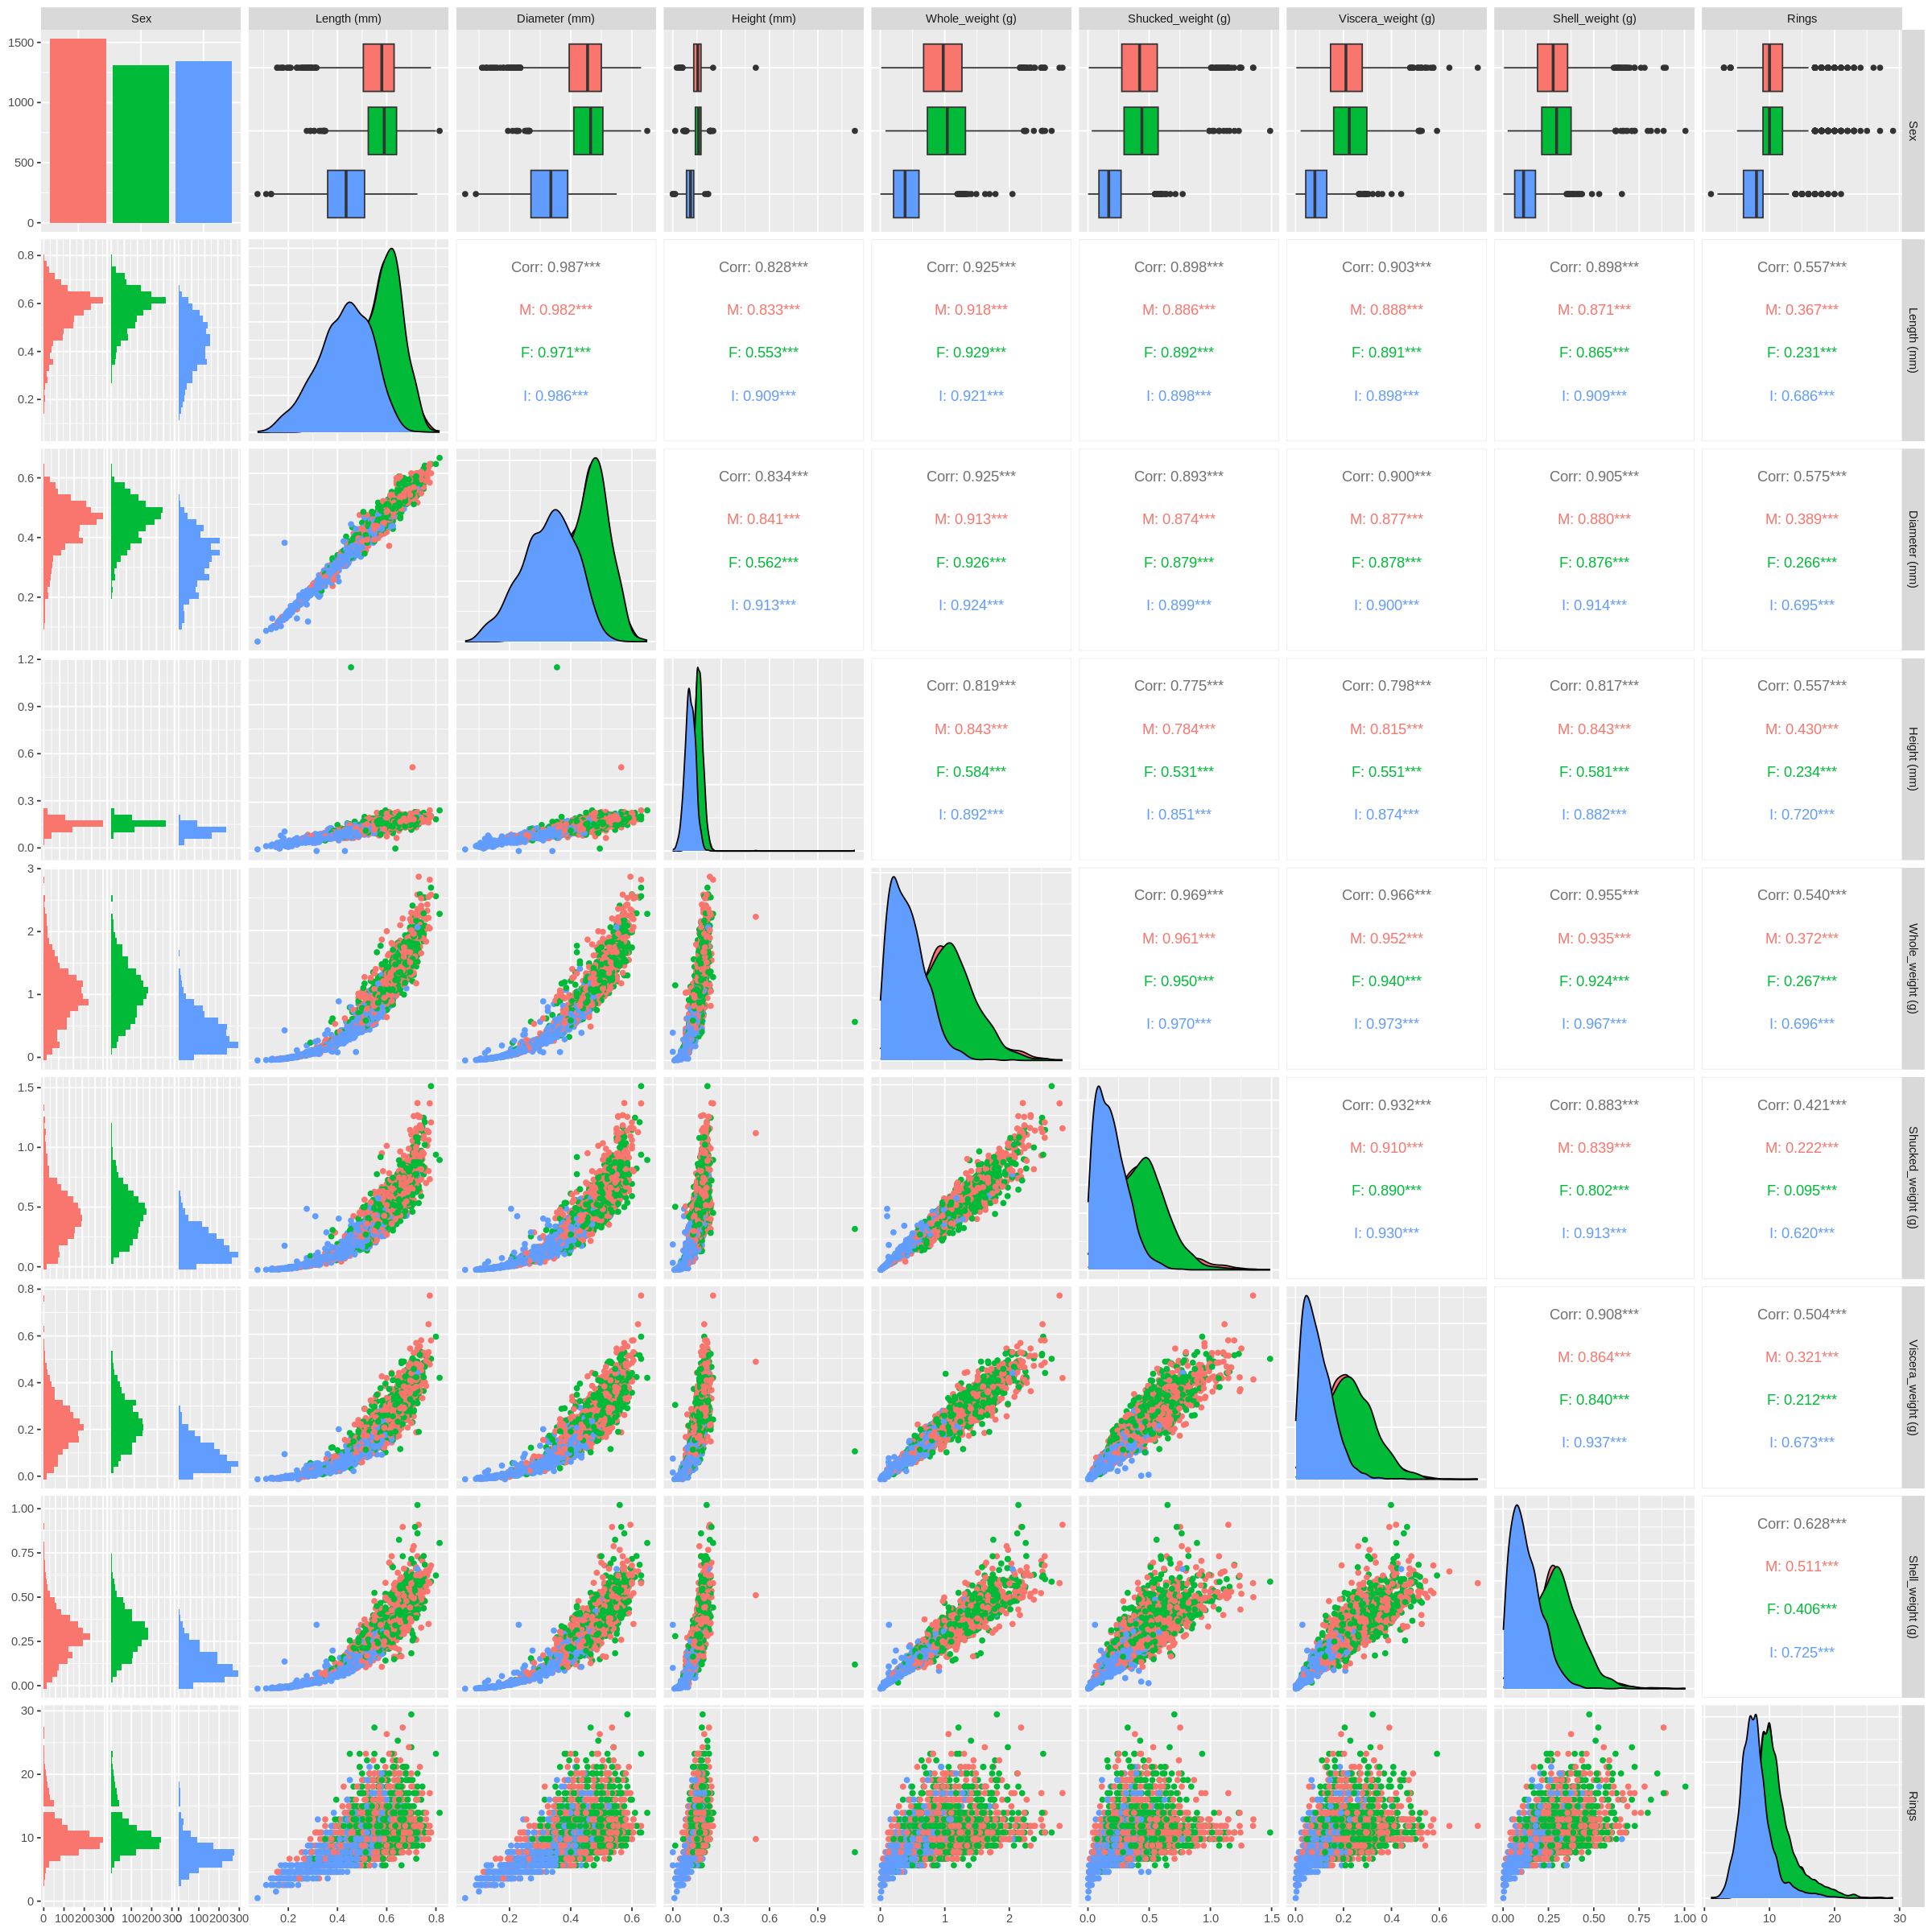

In [4]:
options(repr.plot.width=20,repr.plot.height=20)
ggpairs(data,
        aes(color = `Sex`))

**Methods and Plan**

My question of interest is predicting the number of rings of an Abalone using the physical characteristics that are easily measured, which can infer the age of that snail. We want to find which set of these easily measured characteristics works best. To achieve this, I decided to use Lasso. The rationale behind this choice is that Lasso was designed to optimize prediction, which is my goal. Lasso regression is used for its ability to perform variable selection and regularization. Unlike forward selection, where variables are added sequentially, Lasso simultaneously estimates the coefficients and enforces sparsity by driving some coefficients to exactly zero. This helps in selecting a subset of predictors that contribute significantly to predicting the number of rings in an Abalone.

In this case, Lasso regression is appropriate, as we are trying to predict the number of rings and want to find the best set of predictors. Since we have a lot of different physical characteristics, some of them may not be as significant. Thus, we can use Lasso to select a subset of the most important predictors while setting others to zero. Also, Lasso helps with another major issue that may be present in our data, Multicollinearity. Lasso's regularization term, which includes the L1 penalty, encourages sparsity and helps mitigate the impact of multicollinearity. When predictors are highly correlated, Lasso tends to select one of them while setting the others to zero.

There are a couple of assumptions that I am making. We are assuming that there is a linear relationship between the rings of an Abalone snail and the physical characteristics we have measured. We are also assuming that each observation is independent and assuming there is no multicollinearity, especially between different levels of Sex. In the EDA, I was alerted to the possible presence of multicollinearity in the data, for example, with shucked weight and the whole weight of a snail. However, Lasso should be able to handle multicollinearity, and we can always check in the final model if Multicollinearity is present in the chosen variables. 

One major potential limitation of this method is that we will not capture any interactions between variables effectively, which is something that may be a thing, especially when relating to levels of Sex, as there are some differences in the distribution of variables when we look between Adults and Infants, such as in Length or Whole Weight. Another potential weakness, as discussed earlier, is the potential presence of multicollinearity within the final model. While Lasso regression incorporates a form of automatic variable selection, multicollinearity may persist, especially given the strong correlations observed among many variables in the dataset. 

A potential solution would be to fit some interaction models manually and then use ANOVA test/AIC to choose the best model. I plan on implementing cross-validation to obtain a more realistic assessment of our model's predictive performance. This will allow us to evaluate how well the model generalizes to unseen data. In order to address the multicollinearity problem, it would be best to eliminate the variable with the higher VIF score from the pair of variables that have the highest correlation. High correlations between two predictors does not necessarily mean there is multicollinearity, which is something to keep in mind.



**Implementation of a proposed model**

In [5]:
## Splitting the dataset
set.seed(1)
training_data <- data %>%
    sample_frac(0.8)

testing_data <- data %>%
    setdiff(training_data)

In [6]:
# Creating X and Y for cv model, this was the only way I could get the code to run
y_train <- training_data$Rings
x_train <- data.matrix(training_data[, c("Sex", "Length (mm)", "Diameter (mm)", "Height (mm)", "Whole_weight (g)", "Shucked_weight (g)", "Viscera_weight (g)", "Shell_weight (g)")])
y_test<- testing_data$Rings
x_test <- data.matrix(testing_data[, c("Sex", "Length (mm)", "Diameter (mm)", "Height (mm)", "Whole_weight (g)", "Shucked_weight (g)", "Viscera_weight (g)", "Shell_weight (g)")])

In [7]:
# Use lasso
lasso_model <- cv.glmnet(x_train, y_train, alpha = 1)

lasso_coef = coef(lasso_model, s = lasso_model$lambda[which.min(lasso_model$cvm)])

lasso_selected_covariates <- as_tibble(
        as.matrix(lasso_coef),
        rownames='covariate') %>%
        filter(covariate != '(Intercept)' & abs(s1) !=0) %>% 
        pull('covariate')
lasso_coef
lasso_selected_covariates

9 x 1 sparse Matrix of class "dgCMatrix"
                            s1
(Intercept)          3.7514625
Sex                 -0.3527947
Length (mm)          .        
Diameter (mm)        8.6161480
Height (mm)         22.1790967
Whole_weight (g)     6.7826536
Shucked_weight (g) -17.8971315
Viscera_weight (g)  -7.5994430
Shell_weight (g)    10.3216587

[1] "Sex"                "Diameter (mm)"      "Height (mm)"       
[4] "Whole_weight (g)"   "Shucked_weight (g)" "Viscera_weight (g)"
[7] "Shell_weight (g)"

The above output shows what lasso deemed to be the most important predictors which were computing using the best lambda. 
We see that the coefficent for Length was shrunk to 0, which indicates that its not a good predictor to use. 
One issue I had when I was attempting to use lasso, was how to encode the categorical varaible Sex, even in this final model, it's not as easy to interpret the 3 levels as it was in lm, and this is something that needs more work. 
Based on these results, we know how each variable that is useful in our predicton model selected by lasso relates to the number of Rings.  